In [23]:
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from impyute.imputation.cs import mice
from matplotlib import pyplot
from numpy import argmax

import warnings
warnings.filterwarnings("ignore")

# For Encoding
from sklearn.preprocessing import OneHotEncoder

# For Scaling
from sklearn.preprocessing import StandardScaler, PowerTransformer

# For Model Building
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.utils import shuffle
import xgboost

# For Model Performance
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# For Decision Tree Plotting
import graphviz

# For EDA
from pandas_profiling import ProfileReport

# We begin by starting some simple preprocessing

We want to split the data set into train and test, on top of that we want to extract the target variable from the train and test dataset


In [24]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [25]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Train Test Split

We acknoledge that there is no train-test data for this particular dataset and we want to prevent the case that overfitting occurs due to us overfitting the training set or validation set through countless iterations. To prevent this problem, we will initiate a train-test split to split the original dataset into two files.

<AxesSubplot:xlabel='stroke', ylabel='count'>

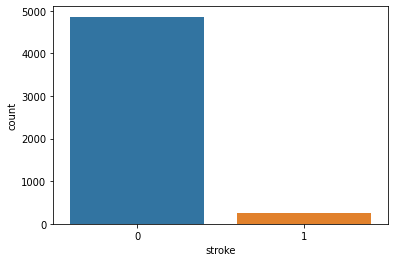

In [26]:
sns.countplot(data["stroke"])

From this, we see that the number of stroke to no stroke has quite a huge disparity. This makes sense as stroke patients are way lesser than non stroke patients. When splitting we will stratify the split so we can keep the proportion between train and test sets.

In [27]:
# df_train, df_test = train_test_split(data, stratify=data.stroke, test_size=0.2, random_state=123)

# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

# df_train.to_csv('train.csv', index=False)
# df_test.to_csv('test.csv', index=False)

# Reimporting the data for further EDA & Preprocessing

In [28]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,60777,Female,31.0,0,0,Yes,Govt_job,Rural,103.55,20.5,formerly smoked,0
1,50545,Male,41.0,0,0,Yes,Govt_job,Urban,84.10,29.3,never smoked,0
2,7195,Male,50.0,0,1,No,Private,Urban,85.82,31.9,never smoked,0
3,27801,Female,34.0,0,0,Yes,Private,Urban,113.26,27.6,never smoked,0
4,31564,Female,25.0,0,0,Yes,Private,Rural,90.65,20.9,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4083,365,Female,44.0,1,0,Yes,Private,Rural,69.48,41.3,never smoked,0
4084,25149,Female,3.0,0,0,No,children,Rural,79.76,15.6,Unknown,0
4085,43364,Male,79.0,1,0,Yes,Private,Rural,75.02,NaN,never smoked,1
4086,45824,Female,77.0,1,0,Yes,Self-employed,Urban,102.01,29.5,Unknown,0


In [29]:
X_train, y_train = train.drop('stroke', axis=1), train['stroke']
X_test, y_test = test.drop('stroke', axis=1), test['stroke']

In [30]:
X_train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,60777,Female,31.0,0,0,Yes,Govt_job,Rural,103.55,20.5,formerly smoked
1,50545,Male,41.0,0,0,Yes,Govt_job,Urban,84.10,29.3,never smoked
2,7195,Male,50.0,0,1,No,Private,Urban,85.82,31.9,never smoked
3,27801,Female,34.0,0,0,Yes,Private,Urban,113.26,27.6,never smoked
4,31564,Female,25.0,0,0,Yes,Private,Rural,90.65,20.9,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
4083,365,Female,44.0,1,0,Yes,Private,Rural,69.48,41.3,never smoked
4084,25149,Female,3.0,0,0,No,children,Rural,79.76,15.6,Unknown
4085,43364,Male,79.0,1,0,Yes,Private,Rural,75.02,NaN,never smoked
4086,45824,Female,77.0,1,0,Yes,Self-employed,Urban,102.01,29.5,Unknown


# We will now conduct EDA on the training data

we start first by investigating the null values

In [31]:
print(X_train.isnull().sum(), y_train.isnull().sum())
print(X_test.isnull().sum(), y_test.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  165
smoking_status         0
dtype: int64 0
id                    0
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  36
smoking_status        0
dtype: int64 0


Note that there is a large disparity between 0 and 1 values hence we might want to stratify the 0 and 1 when we do our train-validation split

In [32]:
profile = ProfileReport(X_train, title="Project Profile")

In [33]:
profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


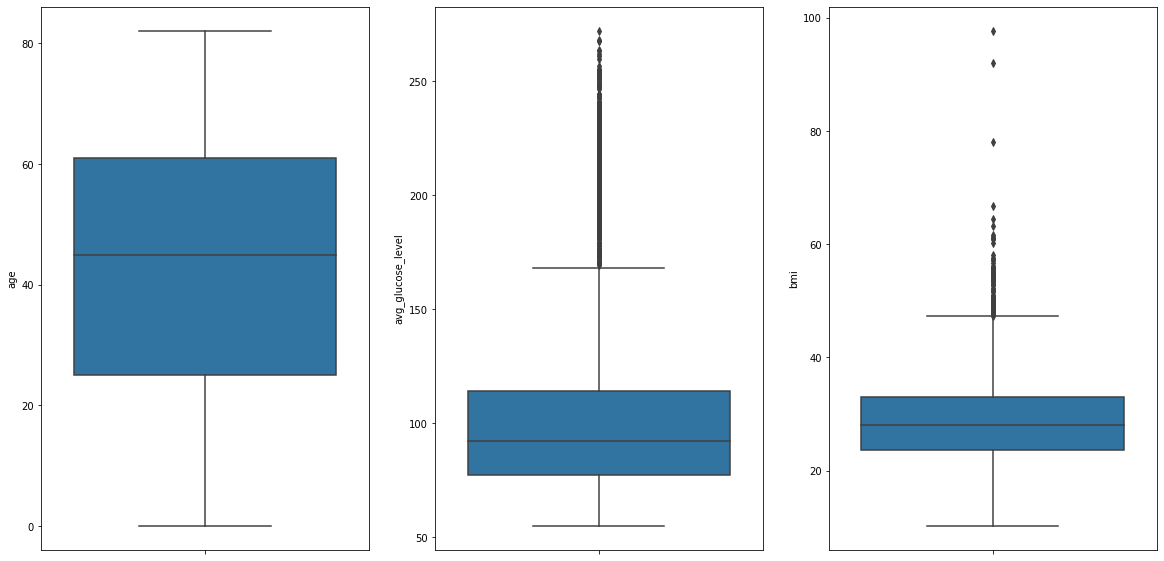

In [34]:
cols = ['age', 'avg_glucose_level', 'bmi']

fig, axs = plt.subplots(1, len(cols), figsize=(20,10))

sns.boxplot(y=X_train['age'], orient='v', ax=axs[0])
sns.boxplot(y=X_train['avg_glucose_level'], orient='v', ax=axs[1])
sns.boxplot(y=X_train['bmi'], orient='v', ax=axs[2])

plt.show()

# Data Preprocessing

We need to do the following:

1) Drop id column | [Both Train & Test]

2) Encoding for categorical variables | [Both Train & Test]

3) Gender 'Others' convert to most frequent class ('Female') | [Both Train & Test]

4) Fill in missing values for bmi using MICE | [Both Train & Test]

5) Standard scaling for age | [Both Train & Test]

6) Log transform avg_glucose_level | [Both Train & Test]

### Drop 'id' column

In [35]:
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

### Encoding the categorical variables
- Male
- Ever married
- Work type
- Residence type
- Smoking Status

In [36]:
X_train = X_train.rename({'gender' : 'is_female'}, axis = 1)
X_train['is_female'] = X_train['is_female'].replace({"Male": 0, 
                                                     "Female": 1})
X_train['ever_married'] = X_train['ever_married'].replace({'Yes': 1,
                                                           'No': 0})
X_train = pd.get_dummies(X_train, columns=['work_type','Residence_type','smoking_status'])

In [37]:
X_train

,is_female,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,31.0,0,0,1,103.55,20.5,1,0,0,0,0,1,0,0,1,0,0
1,0,41.0,0,0,1,84.10,29.3,1,0,0,0,0,0,1,0,0,1,0
2,0,50.0,0,1,0,85.82,31.9,0,0,1,0,0,0,1,0,0,1,0
3,1,34.0,0,0,1,113.26,27.6,0,0,1,0,0,0,1,0,0,1,0
4,1,25.0,0,0,1,90.65,20.9,0,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,1,44.0,1,0,1,69.48,41.3,0,0,1,0,0,1,0,0,0,1,0
4084,1,3.0,0,0,0,79.76,15.6,0,0,0,0,1,1,0,1,0,0,0
4085,0,79.0,1,0,1,75.02,NaN,0,0,1,0,0,1,0,0,0,1,0
4086,1,77.0,1,0,1,102.01,29.5,0,0,0,1,0,0,1,1,0,0,0


In [38]:
X_test = X_test.rename({'gender' : 'is_female'}, axis = 1)
X_test['is_female'] = X_test['is_female'].replace({"Male": 0, 
                                                     "Female": 1})
X_test['ever_married'] = X_test['ever_married'].replace({'Yes': 1,
                                                           'No': 0})
X_test = pd.get_dummies(X_test, columns=['work_type','Residence_type', 'smoking_status'])

### Gender Others convert to female

Anomaly found in train dataset. For consistency, conversion is applied to test dataset as well.

In [39]:
X_train['is_female'] = X_train['is_female'].replace({"Other":1})
X_test['is_female'] = X_test['is_female'].replace({"Other":1})

### Fill in missing values with MICE

In [40]:
# Using mean
X_train_mean = X_train[['bmi']].copy()
X_train_mean['bmi'] = X_train_mean['bmi'].fillna(np.nanmean(X_train_mean['bmi']))
X_train_mean.describe()

,bmi
count,4088.000000
mean,28.931634
std,7.665910
min,10.300000
25%,23.800000
50%,28.500000
75%,32.800000
max,97.600000


In [41]:
# Using median
X_train_median = X_train[['bmi']].copy()
X_train_median['bmi'] = X_train_median['bmi'].fillna(np.nanmedian(X_train_median['bmi']))
X_train_median.describe()

,bmi
count,4088.000000
mean,28.898068
std,7.667658
min,10.300000
25%,23.800000
50%,28.100000
75%,32.800000
max,97.600000


In [42]:
# Using MICE
X_train_mice = pd.DataFrame(mice(X_train.values), columns = X_train.columns)
X_train_mice = X_train_mice[['bmi']]
X_train_mice.describe()

,bmi
count,4088.000000
mean,28.985615
std,7.702061
min,10.300000
25%,23.775000
50%,28.400000
75%,33.021674
max,97.600000


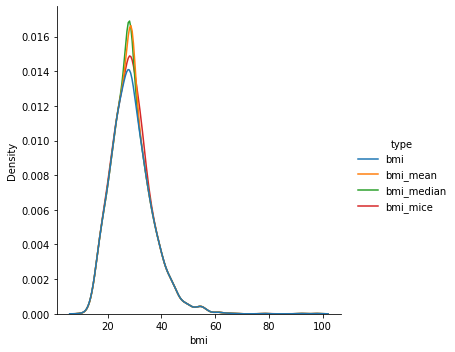

In [46]:
# Distribution Plot
X_train_orig = X_train.copy()

X_train_orig['type'] = 'bmi'
X_train_mean['type'] = 'bmi_mean'
X_train_median['type'] = 'bmi_median'
X_train_mice['type'] = 'bmi_mice'

bmi_plot = pd.concat([X_train_orig[['bmi', 'type']], X_train_mean, X_train_median, X_train_mice])
bmi_plot = bmi_plot.reset_index()

sns.displot(bmi_plot, x = "bmi", hue = 'type', kind = "kde")
plt.show()

In [47]:
# Distribution of MICE imputed values is closest to the original distribution
X_train = pd.DataFrame(mice(X_train.values), columns = X_train.columns)
X_test = pd.DataFrame(mice(X_test.values), columns = X_test.columns)

### Standard Scaling of age

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

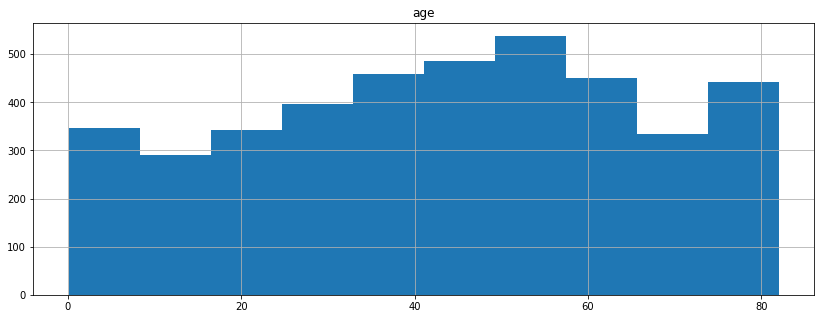

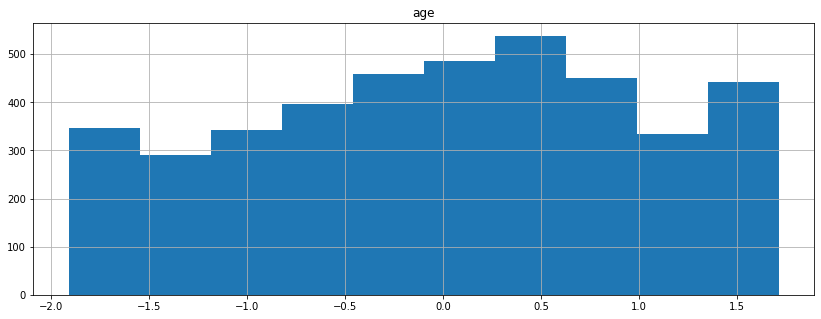

In [48]:
ss = StandardScaler()

# Before Scaling
X_train[["age"]].hist(figsize=(14, 5))

# Apply Scaling
X_train[["age"]] = ss.fit_transform(X_train[["age"]])
X_test[["age"]] = ss.fit_transform(X_test[["age"]])

# After Scaling
X_train[["age"]].hist(figsize=(14, 5))

### Log Transformation of bmi and avg_glucose_level

array([[<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>]], dtype=object)

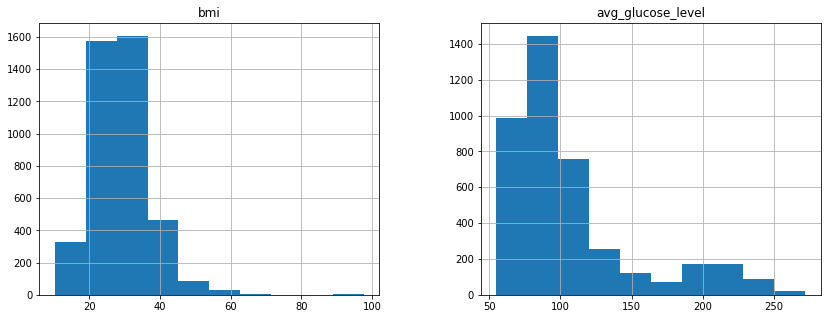

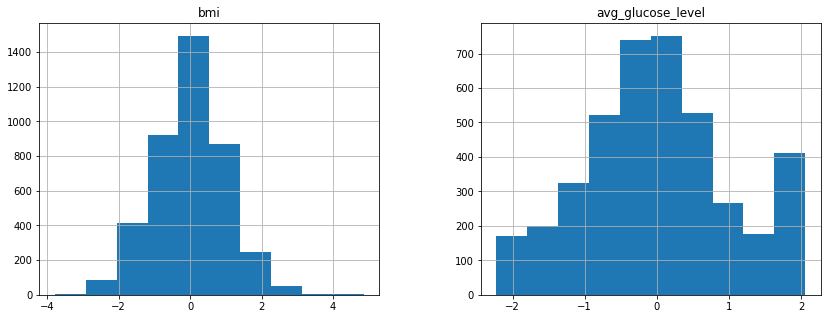

In [49]:
pt = PowerTransformer()

# Before Log Transformation
X_train[["bmi", "avg_glucose_level"]].hist(figsize=(14, 5))

# Apply Log Transformation
X_train[["bmi", "avg_glucose_level"]] = pt.fit_transform(X_train[["bmi", "avg_glucose_level"]])
X_test[["bmi", "avg_glucose_level"]] = pt.fit_transform(X_test[["bmi", "avg_glucose_level"]])

# After Log Transformation
X_train[["bmi", "avg_glucose_level"]].hist(figsize=(14, 5))

# Model Building

We will be trying out 5 different types of models to guage performance:
- Classification Tree (Simple Model)
- Logistic Regression (Simple Model)
- RandomForest (Complex Model)
- XGBoost (Complex Model)
- Convulutional Neural Network (Deep Learning - Very Complex Model)

In [50]:
def get_train_val_scores(search, X_train=X_train, y_train=y_train):
    
    model = search.best_estimator_
    cv_results = pd.DataFrame(search.cv_results_)
    
    best_result = cv_results.iloc[search.best_index_]
   
    train = []
    val = []
    
    for i in range(5):
        train.append(best_result['split'+str(i)+'_train_average_precision'])
        val.append(best_result['split'+str(i)+'_test_average_precision'])
    
    train.append(best_result['mean_train_average_precision'])
    val.append(best_result['mean_test_average_precision'])   
    
    train_val_df = pd.DataFrame({'split': [0, 1, 2, 3, 4, 'mean'], 
                                 'train_average_precision': train, 
                                 'val_average_precision': val})
    
    print("===== TRAIN RESULTS =====")
    print()
    print("Train F2:", round(cv_results['mean_train_f2'][search.best_index_],3))
    print("Train Recall:", round(cv_results['mean_train_recall'][search.best_index_],3))
    print("Train Precision:", round(cv_results['mean_train_precision'][search.best_index_],3))
    print("Train ROCAUC:", round(cv_results['mean_train_auc'][search.best_index_],3))
    print("Train PRAUC:", round(cv_results['mean_train_average_precision'][search.best_index_],3))
    print()
    print("===== VALIDATION RESULTS =====")
    print("Validation F2:", round(cv_results['mean_test_f2'][search.best_index_],3))
    print("Validation Recall:", round(cv_results['mean_test_recall'][search.best_index_],3))
    print("Validation Precision:", round(cv_results['mean_test_precision'][search.best_index_],3))
    print("Validation ROCAUC:", round(cv_results['mean_test_auc'][search.best_index_],3))
    print("Validation PRAUC:", round(cv_results['mean_test_average_precision'][search.best_index_],3))
    
    return train_val_df
    

# Setting the scoring dictionary
scoring = {'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'),
           'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'), 
           'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
           'auc': "roc_auc", 
           'f2': make_scorer(fbeta_score, beta=2),
           'average_precision': make_scorer(average_precision_score)}

# Setting the range for class weights
weights = np.linspace(0.0,1.0,20)

## Classification Tree

In [51]:
%%time 


dt = DecisionTreeClassifier(random_state = 123, 
                            class_weight = 'balanced')


param_grid = {'max_depth' : np.arange(1, 10, 1),
              'min_samples_leaf' : np.arange(100, 800, 10)}

dt_search = GridSearchCV(estimator = dt, param_grid = param_grid, refit = "average_precision", 
                         return_train_score = True, scoring = scoring, cv = 5, verbose = 2, n_jobs = -1)

# Fit GridSearch model
dt_search.fit(X_train, y_train)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
Wall time: 58.1 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 52...
             refit='average_precision', return_train_score=True,
             scoring={'auc': 'roc_auc',
                      'average_precision': make_scorer(average_precision_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'f2': make_scorer(fbeta_score, beta=2),
                      'precision': make_scorer(precision_score, pos_label=1, average=binary),
                      'recall': make

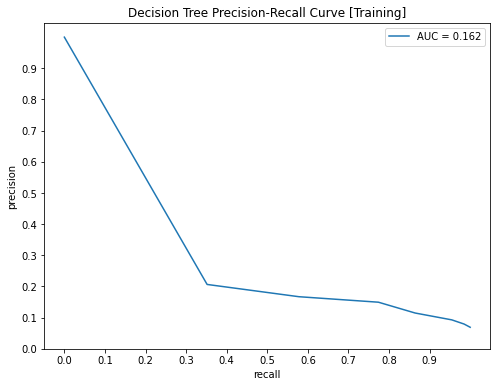

In [52]:
# Training Set
y_pred_proba = dt_search.predict_proba(X_train)[:, 1]
precision, recall, _ = precision_recall_curve(y_train, y_pred_proba)
average_precision = average_precision_score(y_train, y_pred_proba)

plt.figure(figsize = (8,6))
plt.plot(recall, precision, label = 'AUC = %0.3f' % average_precision)
plt.legend(loc = 'upper right')
plt.xlabel('recall')
plt.ylabel('precision')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=0.1))
plt.title('Decision Tree Precision-Recall Curve [Training]')
plt.show()

In [53]:
dt_best = dt_search.best_estimator_

print("Best Estimator:", dt_best)
print()
print("Best Parameters:", dt_search.best_params_)
print()

# Get Train Scores
dt_train_val = get_train_val_scores(dt_search)
dt_train_val

Best Estimator: DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=240, random_state=123)

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 240}

===== TRAIN RESULTS =====

Train F2: 0.421
Train Recall: 0.778
Train Precision: 0.149
Train ROCAUC: 0.84
Train PRAUC: 0.127

===== VALIDATION RESULTS =====
Validation F2: 0.404
Validation Recall: 0.744
Validation Precision: 0.144
Validation ROCAUC: 0.807
Validation PRAUC: 0.119


,split,train_average_precision,val_average_precision
0,0,0.121471,0.115007
1,1,0.129266,0.125682
2,2,0.136275,0.104363
3,3,0.119185,0.126166
4,4,0.127071,0.125305
5,mean,0.126654,0.119304


### Classification Tree Plot 

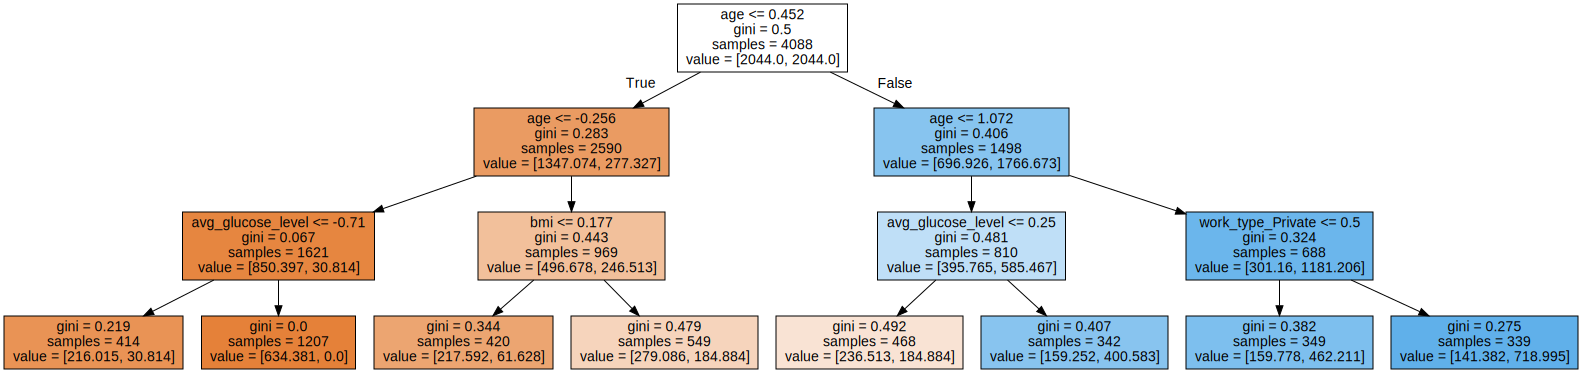

In [54]:
# DOT data
dot_data = tree.export_graphviz(dt_best, 
                                feature_names = X_train.columns,
                                filled = True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [30]:
graph.render("decision_tree")

'decision_tree.png'

## Logistic Regression

In [32]:
%%time 


lr = LogisticRegression(random_state = 123, 
                        penalty = "l1", 
                        max_iter = 150, 
                        solver = "liblinear", 
                        class_weight = 'balanced')


param_grid = {'C':[1.0, 0.1, 0.01, 0.001]}

lr_search = GridSearchCV(estimator = lr, param_grid = param_grid, refit = "average_precision", 
                         return_train_score = True, scoring = scoring, cv = 5, verbose = 2, n_jobs = -1)

# Fit GridSearch model
lr_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: user 130 ms, sys: 12.5 ms, total: 142 ms
Wall time: 508 ms


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=150,
                                          penalty='l1', random_state=123,
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [1.0, 0.1, 0.01, 0.001]},
             refit='average_precision', return_train_score=True,
             scoring={'auc': 'roc_auc',
                      'average_precision': make_scorer(average_precision_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'f2': make_scorer(fbeta_score, beta=2),
                      'precision': make_scorer(precision_score, pos_label=1, average=binary),
                      'recall': make_scorer(recall_score, pos_label=1, average=binary)},
             verbose=2)

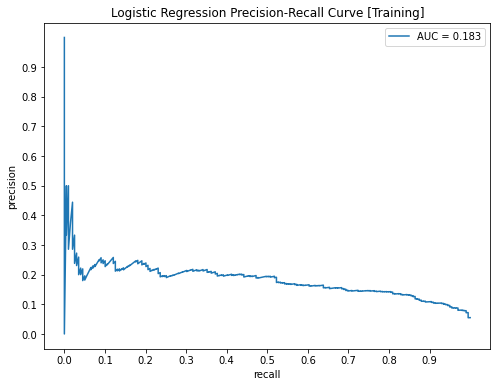

In [33]:
# Training Set
y_pred_proba = lr_search.predict_proba(X_train)[:, 1]
precision, recall, _ = precision_recall_curve(y_train, y_pred_proba)
average_precision = average_precision_score(y_train, y_pred_proba)

plt.figure(figsize = (8,6))
plt.plot(recall, precision, label = 'AUC = %0.3f' % average_precision)
plt.legend(loc = 'upper right')
plt.xlabel('recall')
plt.ylabel('precision')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=0.1))
plt.title('Logistic Regression Precision-Recall Curve [Training]')
plt.show()

In [34]:
lr_best = lr_search.best_estimator_

print("Best Estimator:", lr_best)
print()
print("Best Parameters:", lr_search.best_params_)
print()

# Get Train Scores
lr_train_val = get_train_val_scores(lr_search)
lr_train_val

Best Estimator: LogisticRegression(class_weight='balanced', max_iter=150, penalty='l1',
                   random_state=123, solver='liblinear')

Best Parameters: {'C': 1.0}

===== TRAIN RESULTS =====

Train F2: 0.412
Train Recall: 0.828
Train Precision: 0.137
Train ROCAUC: 0.842
Train PRAUC: 0.122

===== VALIDATION RESULTS =====
Validation F2: 0.403
Validation Recall: 0.809
Validation Precision: 0.134
Validation ROCAUC: 0.83
Validation PRAUC: 0.118


,split,train_average_precision,val_average_precision
0,0,0.123873,0.116004
1,1,0.117106,0.125095
2,2,0.127576,0.108665
3,3,0.120024,0.118591
4,4,0.121355,0.121535
5,mean,0.121987,0.117978


## Random Forest

In [34]:
%%time 


rf = RandomForestClassifier(random_state = 123,
                            class_weight = 'balanced')


param_grid = {'bootstrap': [True, False],
              'max_depth': [5, 10, None],
              'max_features': ['auto', 'sqrt', None],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600]}

rf_search = GridSearchCV(estimator = rf, param_grid = param_grid, refit = "average_precision", 
                         return_train_score = True, scoring = scoring, cv = 5, verbose = 2, n_jobs = -1)

# Fit GridSearch model
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
CPU times: user 8.02 s, sys: 705 ms, total: 8.73 s
Wall time: 37min 37s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, None],
                         'max_features': ['auto', 'sqrt', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600]},
             refit='average_precision', return_train_score=True,
             scoring={'auc': 'roc_auc',
                      'average_precision': make_scorer(average_precision_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'f2': make_scorer(fbeta_score, beta=2),
                      'precision': make_scorer(precision_score, pos_label=1, average=binary),
                      'recall': make_scorer(recall_score, pos_label=1, average=b

In [35]:
# Training Set
y_pred_proba = rf_search.predict_proba(X_train)[:, 1]
precision, recall, _ = precision_recall_curve(y_train, y_pred_proba)
average_precision = average_precision_score(y_train, y_pred_proba)

plt.figure(figsize = (8,6))
plt.plot(recall, precision, label = 'AUC = %0.3f' % average_precision)
plt.legend(loc = 'upper right')
plt.xlabel('recall')
plt.ylabel('precision')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=0.1))
plt.title('Random Forest Precision-Recall Curve [Training]')
plt.show()

In [36]:
rf_best = rf_search.best_estimator_

print("Best Estimator:", rf_best)
print()
print("Best Parameters:", rf_search.best_params_)
print()

# Get Train Scores
rf_train_val = get_train_val_scores(rf_search)
rf_train_val

Best Estimator: RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=None,
                       min_samples_leaf=2, n_estimators=600, random_state=123)

Best Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}

===== TRAIN RESULTS =====

Train F2: 0.509
Train Recall: 0.866
Train Precision: 0.193
Train ROCAUC: 0.916
Train PRAUC: 0.173

===== VALIDATION RESULTS =====
Validation F2: 0.392
Validation Recall: 0.659
Validation Precision: 0.15
Validation ROCAUC: 0.819
Validation PRAUC: 0.116


,split,train_average_precision,val_average_precision
0,0,0.173700,0.104266
1,1,0.166759,0.110126
2,2,0.177655,0.111528
3,3,0.178407,0.141394
4,4,0.170087,0.111331
5,mean,0.173322,0.115729


## XGBoost 

In [26]:
%%time 

class_imbalance = y_train.count() / y_train.sum() 

xgb = xgboost.XGBClassifier(seed = 123, scale_pos_weight = class_imbalance)

param_grid = {'eta': [0.01, 0.1, 1],
              'subsample': [0.5, 0.75, 1], 
              'max_depth': [5, 10, 15, None],
              'max_features': ['auto', 'sqrt', None],
              'min_child_weight': [6, 8, 10],
              'gamma': [0.2, 0.5, 0.8]}

xgb_search = GridSearchCV(estimator = xgb, param_grid = param_grid, refit = 'average_precision',
                          return_train_score = True, scoring = scoring, cv = 5, verbose = 2, n_jobs = -1)

# Fit RandomizedSearch model
xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 20.2min finished


[15:46:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 42.9 s, sys: 3.13 s, total: 46 s
Wall time: 20min 13s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
             refit='average_precision', return_train_score=True,
             scoring={'auc': 'roc_auc',
                      'average_precision': make_scorer(average_precision_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                 

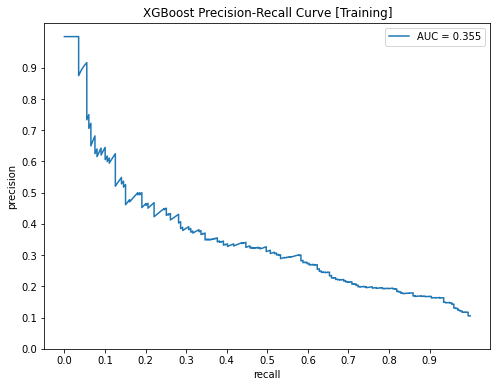

In [27]:
# Training Set
y_pred_proba = xgb_search.predict_proba(X_train)[:, 1]
precision, recall, _ = precision_recall_curve(y_train, y_pred_proba)
average_precision = average_precision_score(y_train, y_pred_proba)

plt.figure(figsize = (8,6))
plt.plot(recall, precision, label = 'AUC = %0.3f' % average_precision)
plt.legend(loc = 'upper right')
plt.xlabel('recall')
plt.ylabel('precision')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=0.1))
plt.title('XGBoost Precision-Recall Curve [Training]')
plt.show()

In [28]:
xgb_best = xgb_search.best_estimator_

print("Best Estimator:", xgb_best)
print()
print("Best Parameters:", xgb_search.best_params_)
print()

# Get Train Scores
xgb_train_val = get_train_val_scores(xgb_search)
xgb_train_val

Best Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0.5,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
              max_features='auto', min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=20.542713567839197, seed=123, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

Best Parameters: {'eta': 0.01, 'gamma': 0.5, 'max_depth': 5, 'max_features': 'auto', 'min_child_weight': 10, 'subsample': 0.5}

===== TRAIN RESULTS =====

Train F2: 0.491
Train Recall: 0.871
Train Precision: 0.179
Train ROCAUC: 0.913
Train PRAUC: 0.162

===== VALIDATION RESULTS =====
Validation F2: 0.395
Validation Rec

,split,train_average_precision,val_average_precision
0,0,0.159043,0.109836
1,1,0.162551,0.118313
2,2,0.172392,0.100778
3,3,0.158786,0.133616
4,4,0.157093,0.117548
5,mean,0.161973,0.116018


# Best Model Optimization

## Tuning Class Weights 

In [35]:
#Setting the range for class weights
w = np.linspace(0.0,0.9,25)

# Create parameter grid
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in w]}

best_model = lr_best

# Create a GridSearchCV object
best_search = GridSearchCV(estimator = best_model,
                           param_grid = param_grid,
                           scoring = scoring,
                           cv = 5,
                           verbose = 2,
                           refit = "average_precision",
                           return_train_score = True)

# Create model 
best_model = best_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] class_weight={0: 0.0, 1: 1.0} ...................................
[CV] .................... class_weight={0: 0.0, 1: 1.0}, total=   0.0s
[CV] class_weight={0: 0.0, 1: 1.0} ...................................
[CV] .................... class_weight={0: 0.0, 1: 1.0}, total=   0.0s
[CV] class_weight={0: 0.0, 1: 1.0} ...................................
[CV] .................... class_weight={0: 0.0, 1: 1.0}, total=   0.0s
[CV] class_weight={0: 0.0, 1: 1.0} ...................................
[CV] .................... class_weight={0: 0.0, 1: 1.0}, total=   0.0s
[CV] class_weight={0: 0.0, 1: 1.0} ...................................
[CV] .................... class_weight={0: 0.0, 1: 1.0}, total=   0.0s
[CV] class_weight={0: 0.0375, 1: 0.9625} .............................
[CV] .............. class_weight={0: 0.0375, 1: 0.9625}, total=   0.0s
[CV] class_weight={0: 0.0375, 1: 0.9625} .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............. class_weight={0: 0.0375, 1: 0.9625}, total=   0.0s
[CV] class_weight={0: 0.0375, 1: 0.9625} .............................
[CV] .............. class_weight={0: 0.0375, 1: 0.9625}, total=   0.0s
[CV] class_weight={0: 0.0375, 1: 0.9625} .............................
[CV] .............. class_weight={0: 0.0375, 1: 0.9625}, total=   0.0s
[CV] class_weight={0: 0.0375, 1: 0.9625} .............................
[CV] .............. class_weight={0: 0.0375, 1: 0.9625}, total=   0.0s
[CV] class_weight={0: 0.075, 1: 0.925} ...............................
[CV] ................ class_weight={0: 0.075, 1: 0.925}, total=   0.0s
[CV] class_weight={0: 0.075, 1: 0.925} ...............................
[CV] ................ class_weight={0: 0.075, 1: 0.925}, total=   0.0s
[CV] class_weight={0: 0.075, 1: 0.925} ...............................
[CV] ................ class_weight={0: 0.075, 1: 0.925}, total=   0.0s
[CV] class_weight={0: 0.075, 1: 0.925} ...............................
[CV] .

[CV] ... class_weight={0: 0.44999999999999996, 1: 0.55}, total=   0.0s
[CV] class_weight={0: 0.4875, 1: 0.5125} .............................
[CV] .............. class_weight={0: 0.4875, 1: 0.5125}, total=   0.0s
[CV] class_weight={0: 0.4875, 1: 0.5125} .............................
[CV] .............. class_weight={0: 0.4875, 1: 0.5125}, total=   0.0s
[CV] class_weight={0: 0.4875, 1: 0.5125} .............................
[CV] .............. class_weight={0: 0.4875, 1: 0.5125}, total=   0.0s
[CV] class_weight={0: 0.4875, 1: 0.5125} .............................
[CV] .............. class_weight={0: 0.4875, 1: 0.5125}, total=   0.0s
[CV] class_weight={0: 0.4875, 1: 0.5125} .............................
[CV] .............. class_weight={0: 0.4875, 1: 0.5125}, total=   0.0s
[CV] class_weight={0: 0.525, 1: 0.475} ...............................
[CV] ................ class_weight={0: 0.525, 1: 0.475}, total=   0.0s
[CV] class_weight={0: 0.525, 1: 0.475} ...............................
[CV] .

[CV] .... class_weight={0: 0.9, 1: 0.09999999999999998}, total=   0.0s
[CV] class_weight={0: 0.9, 1: 0.09999999999999998} ...................
[CV] .... class_weight={0: 0.9, 1: 0.09999999999999998}, total=   0.0s
[CV] class_weight={0: 0.9, 1: 0.09999999999999998} ...................
[CV] .... class_weight={0: 0.9, 1: 0.09999999999999998}, total=   0.0s
[CV] class_weight={0: 0.9, 1: 0.09999999999999998} ...................
[CV] .... class_weight={0: 0.9, 1: 0.09999999999999998}, total=   0.0s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    4.9s finished


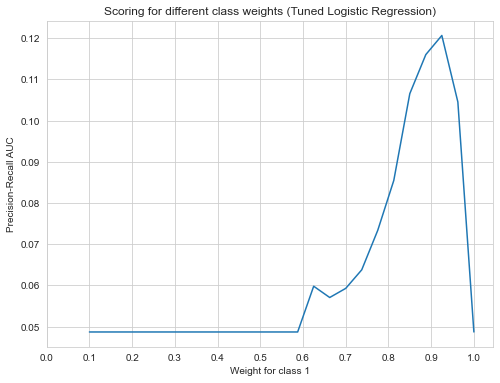

In [36]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
weigh_data = pd.DataFrame({'score': best_search.cv_results_['mean_test_average_precision'], 'weight': (1- w)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Precision-Recall AUC')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights (Tuned Logistic Regression)')
plt.show()

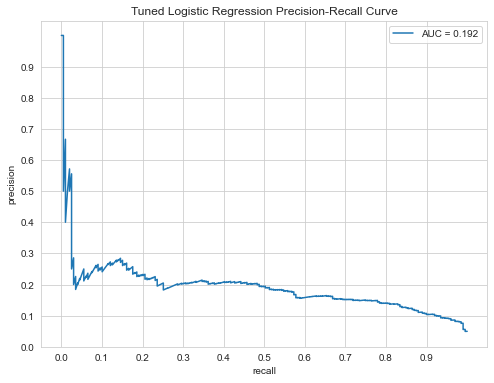

In [37]:
# Training Set
y_pred_proba = best_model.predict_proba(X_train)[:, 1]
precision, recall, _ = precision_recall_curve(y_train, y_pred_proba)
# auc_precision_recall = auc(recall, precision)
average_precision = average_precision_score(y_train, y_pred_proba)

plt.figure(figsize = (8,6))
plt.plot(recall, precision, label = 'AUC = %0.3f' % average_precision)
plt.legend(loc = 'upper right')
plt.xlabel('recall')
plt.ylabel('precision')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=0.1))
plt.title('Tuned Logistic Regression Precision-Recall Curve')
plt.show()

In [38]:
print("Best Estimator:", best_model)
print()
print("Best Parameters:", best_search.best_params_)
print()

# Get Train Scores
best_train_val = get_train_val_scores(best_search)
best_train_val

Best Estimator: GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=150,
                                          penalty='l1', random_state=123,
                                          solver='liblinear'),
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.0375, 1: 0.9625},
                                          {0: 0.075, 1: 0.925},
                                          {0: 0.11249999999999999, 1: 0.8875},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.1875, 1: 0.8125},
                                          {0: 0.22499999999999998, 1: 0.775},
                                          {0: 0.2625, 1: 0.7375},
                                          {0: 0.3, 1: 0.7},
                                          {...
             refit='average_precision', return_train_score=True,
             scoring={'auc': 'roc_

,split,train_average_precision,val_average_precision
0,0,0.128921,0.105143
1,1,0.127240,0.131975
2,2,0.135137,0.110814
3,3,0.116796,0.123395
4,4,0.117958,0.131921
5,mean,0.125210,0.120650


## Benefit Structure 

In [39]:
thresholds = np.arange(0.0, 1.0, 0.2)

In [40]:
def findProbabilityThreshold(tp, fn, fp, tn, model, thresholds, X_train, y_train):
    confusion_matrices = []

    for i in range(0, len(thresholds)):
        threshold = thresholds[i]
        y_pred_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_pred_proba > threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
    
    benefits = []

    for j in range(0, len(thresholds)):
        cm = confusion_matrices[j]
        t_neg = cm[0, 0]
        f_pos = cm[0, 1]
        f_neg = cm[1, 0]
        t_pos = cm[1, 1]
        total = t_neg + f_pos + f_neg + t_pos

        cost_of_tp = tp
        cost_of_fn = fn
        cost_of_fp = fp
        cost_of_tn = tn

        benefit = (t_pos * cost_of_tp
                   + f_neg * cost_of_fn
                   + f_pos * cost_of_fp
                   + (t_pos + f_pos) * cost_of_tn)
        benefits.append(benefit)

    print("Probability Thresholds: ")
    print(thresholds)
    print("Benefits for each probability threshold: ")
    print(benefits)
    
    print("\nBest Probability Threshold & Benefit for " + type(model).__name__ + ":")

    print("Probability Threshold: " + str(thresholds[np.argmax(benefits)] * 100) + "%")
    print("Benefit: " + str(np.max(benefits)))
    
    return thresholds[np.argmax(benefits)]

For Benefit Structure: [TP = +10, FN = -10, FP = -2, TN = -1]

In [41]:
best_threshold = findProbabilityThreshold(10, -10, -2, -1, best_model, thresholds, X_train, y_train)

Probability Thresholds: 
[0.  0.2 0.4 0.6 0.8]
Benefits for each probability threshold: 
[-2466, -974, -510, -260, -450]

Best Probability Threshold & Benefit for GridSearchCV:
Probability Threshold: 60.00000000000001%
Benefit: -260


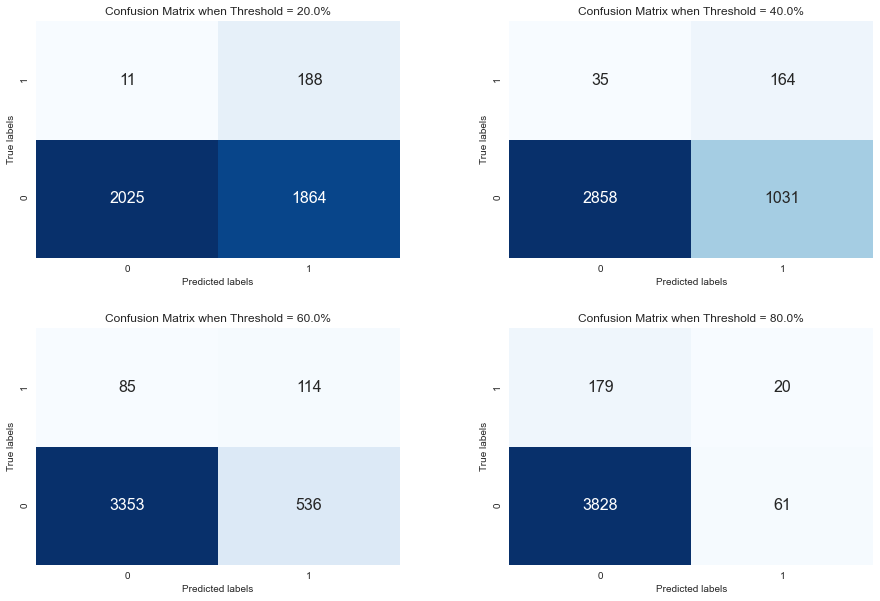

In [42]:
thresholds = [0.2, 0.4, 0.6, 0.8]
confusion_matrices = []
fig, axes = plt.subplots(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1, 5):
    ax = plt.subplot(2, 2, i)
    threshold = thresholds[i-1]
    y_pred_proba = best_model.predict_proba(X_train)[:,1]
    y_pred = (y_pred_proba > threshold).astype(int)
    cm = confusion_matrix(y_train, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    confusion_matrices.append(disp)

    sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues', annot_kws={"fontsize":16})
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix when Threshold = ' + str(threshold*100) + '%');
    ax.set_ylim([0,2])


plt.show()

For Benefit Structure: [TP = +100, FN = -100, FP = -2, TN = -1]

In [43]:
best_threshold = findProbabilityThreshold(100, -100, -2, -1, best_model, thresholds, X_train, y_train)

Probability Thresholds: 
[0.2, 0.4, 0.6, 0.8]
Benefits for each probability threshold: 
[3166, 2370, 1180, -4050]

Best Probability Threshold & Benefit for GridSearchCV:
Probability Threshold: 20.0%
Benefit: 3166


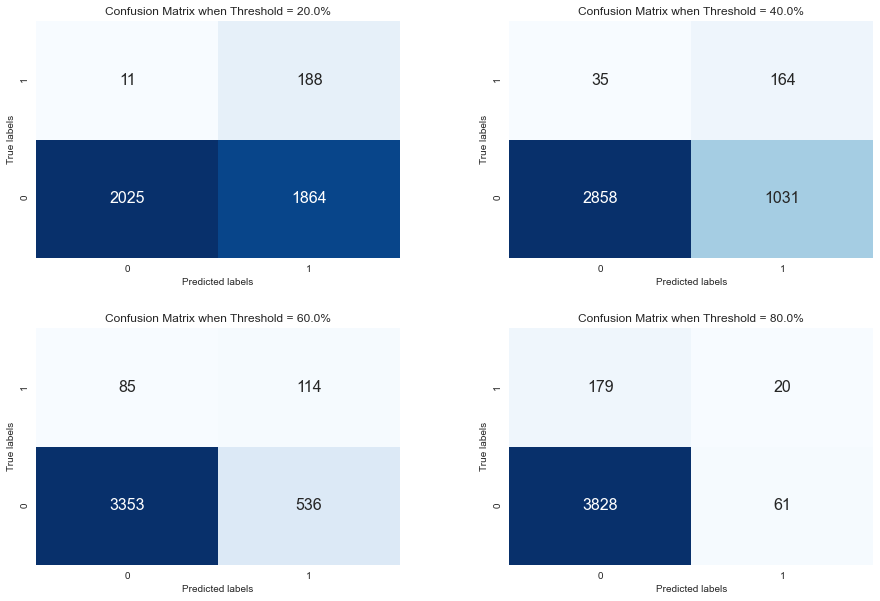

In [44]:
thresholds = [0.2, 0.4, 0.6, 0.8]
confusion_matrices = []
fig, axes = plt.subplots(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1, 5):
    ax = plt.subplot(2, 2, i)
    threshold = thresholds[i-1]
    y_pred_proba = best_model.predict_proba(X_train)[:,1]
    y_pred = (y_pred_proba > threshold).astype(int)
    cm = confusion_matrix(y_train, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    confusion_matrices.append(disp)

    sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues', annot_kws={"fontsize":16})
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix when Threshold = ' + str(threshold*100) + '%');
    ax.set_ylim([0,2])


plt.show()

# Model Evaluation

Train F2: 0.33
Train Recall: 0.945
Train Precision: 0.092
Train ROCAUC: 0.84
Train PRAUC: 0.192

Confusion Matrix:
True Positive: 188
True Negative: 2025
False Positive: 1864
False Negative: 11


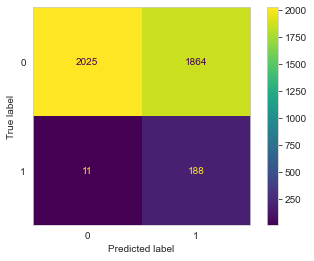

In [45]:
# Apply benefit structure on train and calculate scores
y_pred_proba = best_model.predict_proba(X_train)[:,1]
y_pred = (y_pred_proba > best_threshold).astype(int)

print('Train F2:', round(fbeta_score(y_train, y_pred, beta = 2),3))
print('Train Recall:', round(recall_score(y_train, y_pred),3))
print('Train Precision:', round(precision_score(y_train, y_pred),3))
print('Train ROCAUC:', round(roc_auc_score(y_train, y_pred_proba),3))
print('Train PRAUC:', round(average_precision_score(y_train, y_pred_proba),3))
print()
print('Confusion Matrix:')
cm = confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.grid(b=None)
plt.show()

Test F2: 0.338
Test Recall: 0.96
Test Precision: 0.094
Test ROCAUC: 0.867
Test PRAUC: 0.221

Confusion Matrix:
True Positive: 48
True Negative: 510
False Positive: 462
False Negative: 2


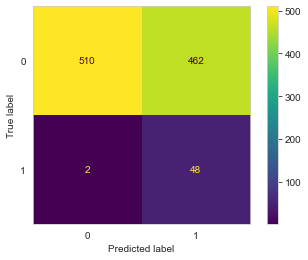

In [46]:
# Apply benefit structure on test and calculate scores
y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba > best_threshold).astype(int)

print('Test F2:', round(fbeta_score(y_test, y_pred, beta = 2),3))
print('Test Recall:', round(recall_score(y_test, y_pred),3))
print('Test Precision:', round(precision_score(y_test, y_pred),3))
print('Test ROCAUC:', round(roc_auc_score(y_test, y_pred_proba),3))
print('Test PRAUC:', round(average_precision_score(y_test, y_pred_proba),3))
print()
print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.grid(b=None)
plt.show()

## Feature Importance 

In [47]:
feature_names = X_train.columns
coef = best_model.best_estimator_.coef_[0]
summary = pd.DataFrame({"Features" : feature_names, "Coefficient": coef}).set_index('Features', drop=True)
summary['Coefficient (abs)'] = summary['Coefficient'].apply(np.abs)
summary.sort_values(by='Coefficient (abs)', ascending=True, inplace = True)
summary

,Coefficient,Coefficient (abs)
Features,,
work_type_Never_worked,0.000000,0.000000
smoking_status_formerly smoked,0.000000,0.000000
Residence_type_Urban,0.000000,0.000000
work_type_Private,0.000000,0.000000
ever_married,0.000000,0.000000
bmi,0.088185,0.088185
is_female,0.103764,0.103764
smoking_status_smokes,0.104649,0.104649
Residence_type_Rural,-0.130035,0.130035


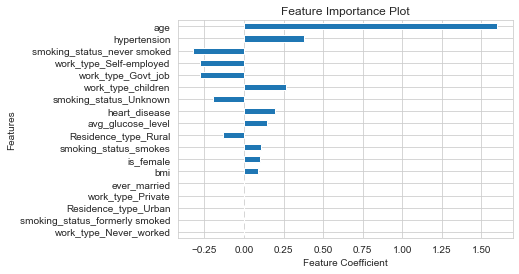

In [48]:
summary.plot.barh(y='Coefficient', title='Feature Importance Plot', legend = False)
plt.xlabel('Feature Coefficient')
plt.show()

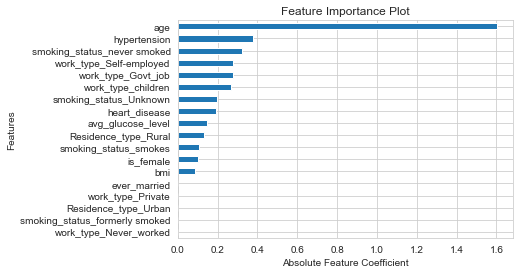

In [49]:
summary.plot.barh(y='Coefficient (abs)', title='Feature Importance Plot', legend = False)
plt.xlabel('Absolute Feature Coefficient')
plt.show()